# LIF MN model

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from typing import Optional

from NeuroMotion.MNPoollib.MNPoolAC import MotoneuronPoolAC

sns.set_theme(style='whitegrid', font_scale=1.1)

In [62]:
def lowpass_filter(
    data: np.ndarray,
    fs: Optional[int] = 2048,
    cutoff: Optional[float] = 500,
    order: Optional[int] = 2,
    filtfilt: Optional[bool] = True,
    ) -> np.ndarray:

    """
    Apply a lowpass filter to the input data.

    Parameters:
        data (np.ndarray): The input data to be filtered.
        fs (Optional[int]): The sampling frequency of the data. Default is 2048.
        cutoff (Optional[list]): Low cutoff frequency of the filter. Default is 20.
        order (Optional[int]): The order of the filter. Default is 4.
        filtfilt (Optional[bool]): Whether to use forward-backward filtering.
            Default is True.

    Returns:
        np.ndarray: The filtered data.

    """
    # Define filter
    sos = signal.butter(order, cutoff, btype='high', fs=fs, output='sos')

    # Apply filter
    if filtfilt:
        out = signal.sosfiltfilt(sos, data, axis=-1)
    else:
        out = signal.sosfilt(sos, data, axis=-1)

    return out


## Evaluate activations

In [63]:
# Test example
num_mu = 100
ms_label = 'ECRB'
mn_pool = MotoneuronPoolAC(num_mu, ms_label)

fs = 2048           # Hz
step_size = 1 / fs  # s

duration = 6        # s
times = np.linspace(0, duration, duration * fs)

ext_type = 'trap'
ext_level = 1

if ext_type == 'iso':
    ext = np.ones(duration * fs) * ext_level
else:
    ext = np.arange(0, duration, step_size) / duration * ext_level
    start = 1
    ramp = 1
    ext = np.concatenate((np.zeros(start * fs), np.arange(0, ramp, 1 / fs) / ramp * ext_level, np.ones(int((duration // 2 - start - ramp) * fs))))
    ext = np.concatenate((ext, ext[::-1]))

n_spike_trains, firing_samples, cst, firing_times_sim = mn_pool.get_binary_spikes(ext, step_size, duration)

pth = os.path.join(os.environ['HOME'], 'NeuroMotion/figs/onion_skin_ac_constant.svg')
mn_pool.display_onion_skin_theory(firing_times_sim, n_spike_trains, duration, pth)

Simulating mn n° 20 79
Simulating mn n° 40 75
Simulating mn n° 60 67
Simulating mn n° 80 57
Simulating mn n° 100 36


## Evaluate common inputs

In [64]:
# Initialise random number generator
rng = np.random.default_rng()

# Define properties
comps = 4
samples = duration * fs
neurons = 10

# Initialise inputs (common synaptic, independent noise)
c_in = rng.normal(size=(comps, samples))
n_i = rng.normal(size=(neurons, samples))

# Filter inputs
c_in_filt = lowpass_filter(c_in, fs=fs, cutoff=2.5, order=4, filtfilt=False)
n_i_filt = lowpass_filter(n_i, fs=fs, cutoff=50, order=4, filtfilt=False)
n_c_filt = c_in_filt.mean(0)

print(c_in.shape, n_c.shape, n_i.shape)

(4, 12288) (12288,) (10, 12288)


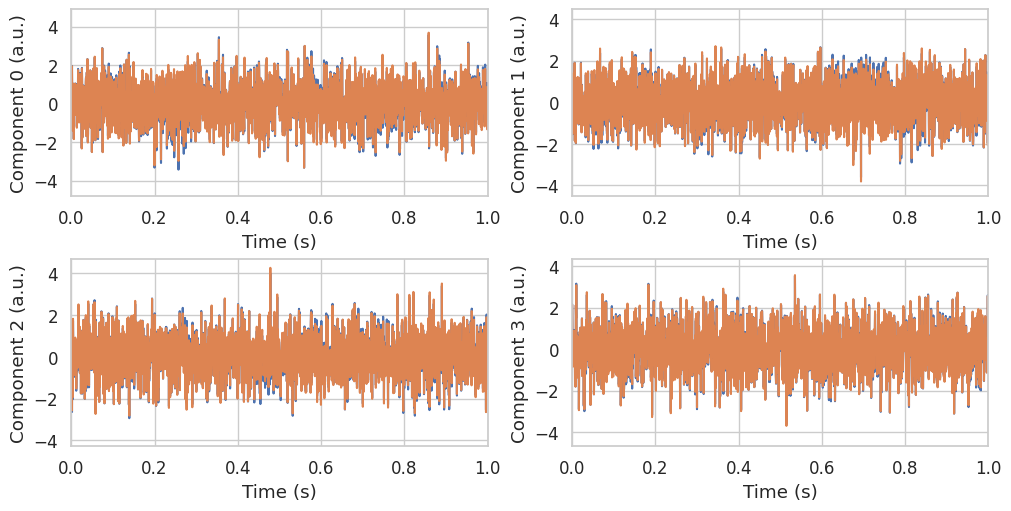

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(10,5), layout='constrained')
axs = np.ravel(axs)

for i in range(comps):
    axs[i].plot(times, c_in[i])
    axs[i].plot(times, c_in_filt[i])
    axs[i].set(ylabel=f'Component {i} (a.u.)', xlabel='Time (s)', xlim=[0, 1])

plt.show()


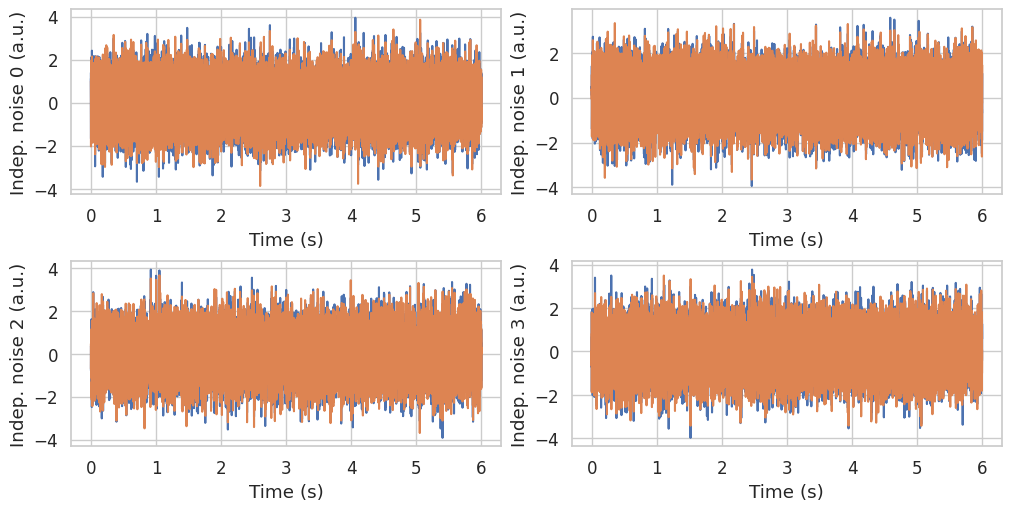

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(10,5), layout='constrained')
axs = np.ravel(axs)

for i in range(comps):
    axs[i].plot(times, n_i[i])
    axs[i].plot(times, n_i_filt[i])
    axs[i].set(ylabel=f'Indep. noise {i} (a.u.)', xlabel='Time (s)')

plt.show()